In [3]:
from scipy import interpolate

import numpy as np
import matplotlib.pylab as plt

from astropy.io import fits
from astropy.table import Table

# KPF Throughput HD34816

## Main Spectrometer

Here we show an example of running the throughput for the data taken on HD34816. The seeing as recorded in the log for this night was around 0.55. We are computing the throughput of the main spectrometer (mode='kpf') and therefore the file containing the expected throughput that we are trying to validate is updated to 'transmission_kpf.txt'. The kpf_file has been downloaded into inputs/HD34816/ - the file chosen showed the highest thorughput for the series taken which included several pointing offsets, which can be seen by plotting the spectra on top one another or looking at the counts in the quicklook plots.  

We will look into how the compute_throughput function works later. It relies on other functions defined in 'calc_throughput_tools'

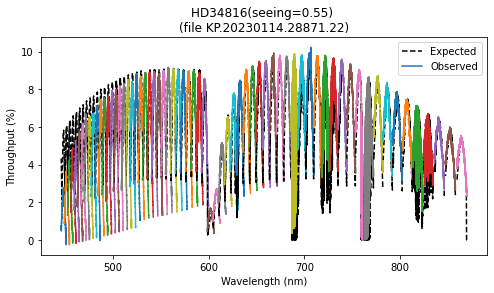

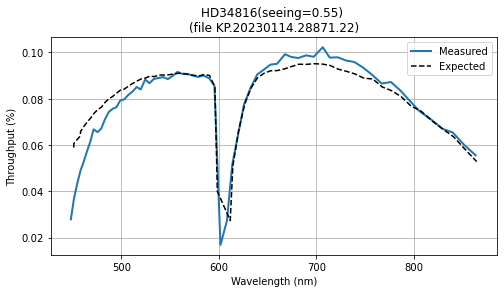

In [5]:
from calc_throughput_tools import compute_throughput, plot_throughput, plot_throughput_peaks

mode='kpf'
starname = 'HD34816'
expected_throughput_file='inputs/throughput_models/transmission_kpf.txt'
kpf_file                = 'inputs/HD34816/KP.20230114.28871.22_L1.fits'
standard_spec_file      = 'inputs/HD34816/lamlep_mod_004.fits' # this might have to be made depending on source of model 
seeing                  = 0.55 # take from log

xdat, measured_throughput, expected_throughput = compute_throughput(kpf_file,standard_spec_file,mode=mode,seeing=seeing,expected_throughput_file=expected_throughput_file)

title = starname + '(seeing=%s) \n(file %s)'%(seeing,kpf_file.split('/')[-1].strip('_L1.fits'))
plot_throughput(xdat, measured_throughput, expected_throughput,fac=1,title=title)
plot_throughput_peaks(xdat, measured_throughput, expected_throughput,fac=1,title=title)


## Ca H&K

Here we rerun for the H&K Spectrometer - we need to update mode to 'hk' and the expected throughput file to that determined for the H&K spectrograph. The KPF data chosen contains H&K data - the best data chosen for the main spectrograph had the H&K spectrometer turned off so no HK data was acquired.

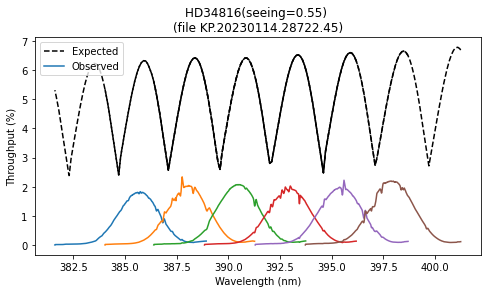

In [6]:
mode='hk'
expected_throughput_file= 'inputs/throughput_models/hk_transmission_total_042921.txt'
kpf_file                = 'inputs/HD34816/KP.20230114.28722.45_L1.fits'

xdat, measured_throughput, expected_throughput = compute_throughput(kpf_file,standard_spec_file,mode=mode,seeing=seeing,expected_throughput_file=expected_throughput_file)

title = starname + '(seeing=%s) \n(file %s)'%(seeing,kpf_file.split('/')[-1].strip('_L1.fits'))
plot_throughput(xdat, measured_throughput, expected_throughput,fac=1,title=title)


## Exposure Meter

To run the exposure meter, we update the mode to 'em' and switch the expected throughput file again and update the data file used. 


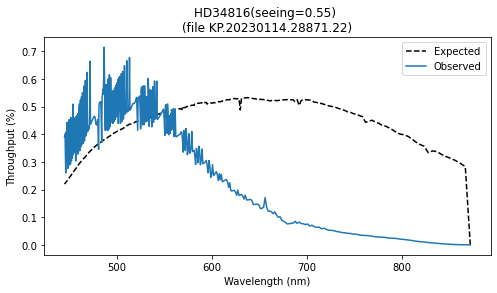

In [7]:
mode     ='em' # exposure meter
expected_throughput_file= 'inputs/throughput_models/exposuremeter_FWHM_0.70arcsec.csv'
kpf_file                = 'inputs/HD34816/L0/KP.20230114.28871.22.fits'

xdat, measured_throughput, expected_throughput = compute_throughput(kpf_file,standard_spec_file,mode=mode,seeing=seeing,expected_throughput_file=expected_throughput_file)

# Plot
title = starname + '(seeing=%s) \n(file %s)'%(seeing,kpf_file.split('/')[-1].strip('_L1.fits'))
plot_throughput(xdat, measured_throughput, expected_throughput,fac=1,title=title)


# Behind the scenes

## Loading the standard star spectra

The standard star spectra are taken from databases:  
- https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec
- https://noirlab.edu/science/observing-noirlab/observing-ctio/Spectrophotometric-Standards/Massey

The data are converted to erg/s/cm2/A and the wavelengths are converted to Angstroms. The load_standard_spec function takes the exposure time and converts the spectrum into photons/A and returns the wavelengths into nanometers to match the KPF data.

The Massey files are csv files in units of AB mag. For this the function 'mod_abmag' can be used to convered the AB magnitudes into erg/s/cm2/A and saved into a fits file in the same format as the calspec data, which works with the 'load_standard_spec' function.


In [9]:
def load_standard_spec(filename,exptime=20):
    """
    load flux standard spectrum

    units of model data: erg s-1 cm-2 A-1
    model wave units: A

    units of output: 
    ymod_phot_ang: photons per angstrom, 
    xmod_new: nanometers
    """
    fmod = fits.open(filename)
    #fstis = fits.open('10lac_stis_006.fits')

    xmod,ymod = fmod[1].data['WAVELENGTH'], fmod[1].data['FLUX']
    isub = np.where(xmod < 9000)[0]
    xmod,ymod = xmod[isub],ymod[isub]

    # resample onto finer and equal grid
    fint = interpolate.interp1d(xmod,ymod,bounds_error=False,fill_value=0)
    xmod_new = 10*np.arange(380,900,0.001) # angstrom
    ymod_new = fint(xmod_new)

    ymod_photdensity = ymod_new * 5.03e7 * xmod_new # now in phot/cm2/A/s - from harvard page ..times lambda

    #exptime=20#s , header has 600s but that is wrong
    keck_area = 75.76 #m2
    cm_per_meter = 100 #cm/m

    # modify ymod to phot/A
    ymod_phot_ang = ymod_photdensity * exptime*keck_area*cm_per_meter**2
    xmod_new/=10 # convert to nanometers

    return xmod_new, ymod_phot_ang 

def mod_abmag(filename ='./mhr4544.csv'):
    """
    open ab mag csv file and resave as fits file in uniots of  egs/cm2/s/A

    checked if conversion worked by opening fhr4544 file which is in uniots
    of egs/cm2/s/A --> it matches

    """
    f = np.loadtxt(filename).T
    x,y = f[0],f[1]

    # convert ab mag to flux
    #https://en.wikipedia.org/wiki/AB_magnitude
    y_ergdens_hz  = 10**((y+48.6)/-2.5) #erg s−1 cm−2 Hz−1
    y_ergdens_ang = y_ergdens_hz * 3e18 / x**2

    cols=[]
    cols.append(fits.Column(name='WAVELENGTH', format='D', array=x))
    cols.append(fits.Column(name='FLUX', format='D', array=y_ergdens_ang))

    primary_hdu = fits.PrimaryHDU()

    tbhdu = fits.BinTableHDU.from_columns(cols)
    hdu = fits.HDUList([primary_hdu,tbhdu])
    hdu.writeto(filename.strip('csv')+'fits',overwrite=True)


## Seeing Adjustment

The fiber coupling of KPF will change in different seeing conditions. The function 'calc_coupling' takes the seeing and fiber size in arcseconds and computes the overlap of the seeing disk onto the fiber. The throughput data for KPF assumes 0.7" seeing so making an adjustment on the throughput also requires dividing out the coupling for seeing=0.7".

In [30]:
def calc_coupling(seeing=0.7,fiber_size=1.14):
    """
    make moffat function, integrate in 3 dimensions, 
    sum that integral out to KPF fiber bounds
    checked it matches steve's results
    Returns the overlap into the fiber

    inputs
    ------
    seeing: [arcsec]
        seeing for the observation
    fiber_size [arcsec]
        fiber size

    outputs:
    -------
    inFiber 
        the fraction of light coupled into the fiber
    """
    #def moffat(theta,seeing):

    #return I_of_theta

    theta = np.arange(0,30,0.001)

    HW = seeing/2.0
    num1 = (2**(1/7) - 1) * (7-1) * 0.8
    den1 = (1+(2**(1/7) - 1)*(theta/HW)**2)**7
    num2 = (2**0.5 - 1)*(2-1)*0.2
    den2 = (1+(2**0.5 -1)*(theta/HW)**2)**2
    coeff= (1/np.pi/HW**2)
    I_of_theta = coeff * (num1/den1 + num2/den2)

    #moffat_image = np.zeros((len(theta),len(theta)))
    #for i, th1 in enumerate(theta):
    #	for j, th2 in enumerate(theta):
    #		theta_temp =  np.sqrt(th1**2  + th2**2)
    #		moffat_image[i,j] = moffat(theta_temp,seeing)

    Inew      = np.zeros_like(theta)
    for i,th in enumerate(theta):
        Inew[i] = 2*np.pi*i * I_of_theta[i]

    #KPF_fiber_size = 4.4 #arcsec, edge to edge
    isub = np.where(theta < fiber_size/2.)

    inKPF = np.trapz(Inew[isub], theta[isub])
    allLight = np.trapz(Inew,theta)

    inFiber = inKPF/allLight

    return inFiber

Text(0, 0.5, 'Fiber Coupling')

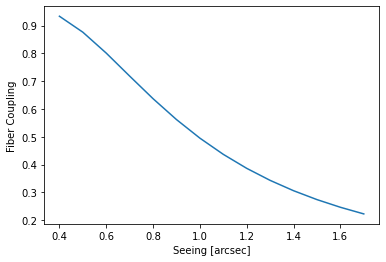

In [34]:
# a look at fiber coupling vs seeing
seeing_arr   = np.arange(0.4,1.8,0.1)
coupling = []
for seeing in seeing_arr:
    coupling.append(calc_coupling(seeing=seeing,fiber_size=1.14))

plt.figure()
plt.plot(seeing_arr,np.array(coupling))
plt.xlabel('Seeing [arcsec]')
plt.ylabel('Fiber Coupling')

## Telluric and Rayleigh Scattering

The telluric model was generated for Mauna Kea during a summer month. The Rayleigh scattering was found to be underestimated in comparison to when the model was run at lower resolution and even lower when compared to actual measurements (from https://www.aanda.org/articles/aa/pdf/2013/01/aa19834-12.pdf)

To load the telluric model, we open the PSF file at high resolution, then load the low resolution data and adjust that to match the Mauna Kea average Rayleigh scattering curve. This is important to better estimate the blue end of the throughput.

Here we show the Rayleigh curve from the model compared to the MK observations. Scaling by 1.5 (as if airmass were 1.5 instead of 1) makes the two match.

Text(0, 0.5, 'Transmission')

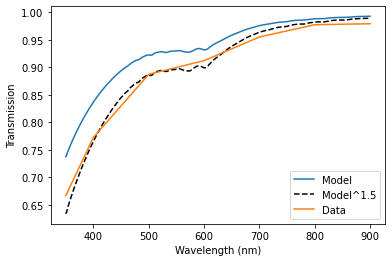

In [28]:
# By eye data from Figure 12 in Supernova Factory paper (mag/airmass)
MKobservations = np.array([[350,0.44], [400, 0.28], [500, 0.13],[600, 0.1], [700, 0.05], [800, 0.025], [900, 0.023]])

# load low res Rayleigh and O3 model for MK
f = np.loadtxt('./inputs/telluric/psg_trn.txt').T
wav, o3, ray = f[0], f[4], f[10]

# plot the model and the data
plt.figure()
plt.plot(wav,(o3*ray),label='Model')
plt.plot(wav,(o3*ray)**1.5,'k--',label='Model^1.5') # factor of 1.5 applied to make them match
plt.plot(MKobservations[:,0],10**(-0.4*MKobservations[:,1]), label='Data') # convert mag to flux ratio
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmission')

## Computing the Throughput

Finally here we show how we compute the throughput. The calculation steps through each wavelength, xi, in the data wavelength array and finds dx in Angstroms which it multiplies by the spectral standard flux (photons/Angstrom) to get the photons expected in that wavelength bin. The throughput is then the data (in photons) divided by the standard star photons at the top of the atmosphere. 

The expected throughput based on the instrument transmission model is modified by the seeing ratio and the telluric transmission to adjust it to match the throughput expected for the given observing conditions. Both the measured throughput and expected throughput therefore consider losses due to telluric absorption and fiber coupling for the respective seeing. 

This method ignores resolution degredation and one might prefer to degrade the resolution of the stellar model and the telluric spectrum for more accuracy.

In [29]:
def compute_throughput(kpf_file,standard_spec_file,mode='kpf',seeing=1,expected_throughput_file='../transmission_kpf.txt'):
    """
    Loads files and computes the throughput for the observation. Computed per wavelength bin

    inputs:
    -------
    kpf_file (str)
        filename of KPF file to consider, EM must be L0 file, otherwise give it L1 file
    standard_spec_file (str)
        file  

    """
    # load data depending on mode
    if mode=='kpf': xdat,ydat,exptime,airmass,xpo,ypo   = load_kpf_data(kpf_file)
    if mode=='em':  xdat,ydat,exptime,airmass,note      = load_em_data(kpf_file)
    if mode=='hk':  xdat,ydat,exptime,airmass,note      = load_hk_data(kpf_file)

    # Number of orders, em is 1
    Norders = np.shape(xdat)[0] 
    
    # load standard star data and telluric spectrum and model throughput file
    x_star,y_star         = load_standard_spec(standard_spec_file,exptime=exptime)
    x_telluric,y_telluric = load_telluric(airmass=airmass,pwv=1.5) # pwv doesnt matter much
    try:
        kpf_throughput_x, kpf_throughput_y = np.loadtxt(expected_throughput_file,delimiter=',').T
    except:
        kpf_throughput_x, kpf_throughput_y = np.loadtxt(expected_throughput_file).T # HK file has space delimiters..
 
    # make interpolation functions for model components
    star_interp     = interpolate.interp1d(x_star,y_star,bounds_error=False,fill_value=0)
    telluric_interp = interpolate.interp1d(x_telluric,y_telluric,bounds_error=False,fill_value=0)
    kpf_throughput_interp  = interpolate.interp1d(kpf_throughput_x, kpf_throughput_y,bounds_error=False,fill_value=0)

    # calc seeing factor to adjust to seeing conditions
    seeing_ratio = calc_coupling(seeing=seeing)/calc_coupling(seeing=0.7) # steve assumes 0.7 in throughput model

    # initialize storage
    measured_throughput = np.zeros_like(xdat)
    expected_throughput = np.zeros_like(xdat)
    
    # loop through orders to get model photons using flux density
    for order in np.arange(Norders):
        # reinterp model on data to divide to get throughput
        ymod_temp = np.zeros_like(ydat[order])
        for i,xi in enumerate(xdat[order]):
            if xi==xdat[order][-1]: 
                ymod_temp[i] = ymod_temp[i-1]
                continue
            model_photons_per_ang = star_interp(xi) # the phot/ang at this wavelength
            # calculation done here:  F_ang [phot/ang] * dx [ang] where dx is wavelength element of pixel in real data array
            ymod_temp[i] = model_photons_per_ang * 10*np.abs((xdat[order][i+1] - xdat[order][i])) # 10 is to convert to angstroms
        # store measured throughput as data / model
        measured_throughput[order] = ydat[order]/ymod_temp
        # store expected throughput 
        expected_throughput[order] = seeing_ratio * kpf_throughput_interp(xdat[order])*telluric_interp(xdat[order]) #throughput  model times telluric spec

    return xdat, measured_throughput, expected_throughput

